# JAX

## Computing Gradients

The `jax.grad()` function forms the core of the auto-diff functionality offered by JAX. It only supports differentiation of scalar valued functions. For vector valued functions, the jacobian can be computed using one of the ways shown in the next section. (Note: all of the jacobian related methods also use `grad` as their workhorse.)

For comparison, I have also included the Pytorch code that uses `torch.autograd.backward()` to achieve the same result as JAX. I have included my remarks below as my reasoning behind recommending JAX over Pytorch for this project.

We start with a simple scalar function $f: \mathbb{R} \longrightarrow \mathbb{R}$
$$f(x) = x^3 + 2x^2 + x$$


In [40]:
import jax.numpy as jnp

def f(x):
    return x**3 + 2*x**2 + x

$$\nabla f (x) = 3x^2 + 4x + 1$$

In [41]:
# JAX
from jax import grad

grad(f)(2.)  # gradient of f at x = 2

Array(21., dtype=float32, weak_type=True)

In [42]:
# Pytorch
import torch

# NOTE: pytorch requires functions that are to be differentiated to accept
# tensors as arguments. Moreover, each of these tensors must have
# their `requires_grad=True`.

p = torch.tensor(2., requires_grad=True)
z = f(p)
z.backward()
p.grad  # gradient of f at x = 2

tensor(21.)

Next, we take a scalar valued function of several variables $f: \mathbb{R}^2 \longrightarrow \mathbb{R}$

$$f(x, y) = \frac{1}{3}x^3 + 2 x y + \frac{1}{3} y ^3$$

In [43]:
def f(x, y):
    return (1./3) * x**3 + 2 * x * y + (1./3) * y**3

$$\nabla f(x, y) = (x^2 + 2y,\ 2x + y^2)$$

In [44]:
# JAX

grad(f, 0)(2., 2.)  # partial of f w.r.t. x at (2, 2)

Array(8., dtype=float32, weak_type=True)

In [45]:
grad(f, 1)(2., 2.)  # partial of f w.r.t. y at (2, 2)

Array(8., dtype=float32, weak_type=True)

In [46]:
grad(f, (0, 1))(2., 2.)  # total gradient of f at (2, 2)

(Array(8., dtype=float32, weak_type=True),
 Array(8., dtype=float32, weak_type=True))

JAX provides the `jit` method to compile code for speedups.

In [59]:
from jax import jit

# compute time test
grad_f = jit(grad(f, (0, 1)))
%timeit grad_f(2., 2.)

21.4 μs ± 295 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [60]:
# Pytorch

p = torch.tensor(2., requires_grad=True)
q = torch.tensor(2., requires_grad=True)
z = f(p, q)
z.backward()
print(p.grad) # partial of f w.r.t. x at (2, 2)
print(q.grad) # partial of f w.r.t. y at (2, 2)

tensor(8.)
tensor(8.)


In [61]:
# compute time test
p = torch.tensor(2., requires_grad=True)
q = torch.tensor(2., requires_grad=True)

%timeit f(p, q).backward()

172 μs ± 876 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**Remark**: 

1. JAX api seem much more natural (and math-like) than PyTorch
2. JAX also beats PyTorch (at least anecdotally) in compute time for simple gradient computation. This gradient computation is at the core of all higher order derivative computations and I would be surprised if Pytorch can beat JAX for higher order derivatives.
3. Pytorch's methods for computing jacobian-vector-products are still in beta phase (https://pytorch.org/docs/stable/autograd.html)

I recommend that we use JAX for this project.

"*If your primary concern is achieving the best possible performance for large-scale numerical computations and you are comfortable with or willing to learn a functional programming style, JAX is likely the better choice. Its performance optimizations and efficient handling of large matrices can provide significant speedups. 
On the other hand, if you prefer a more extensive ecosystem, better documentation, and a larger community for support, PyTorch is a solid choice. It is more user-friendly, especially if you are already familiar with its dynamic computation graph and other features.*" - ChatGPT


## Computing Jacobians

Consider the function $f: \mathbb{R}^2 \longrightarrow \mathbb{R}$
$$f(\mathbf{x}  ) = \frac{1}{3}x_1^3 + 2 x_1 x_2 + \frac{1}{3} x_2 ^3$$

In [68]:
def f(x):
    return (1./3) * x[0]**3 + 2 * x[0] * x[1] + (1./3) * x[1] ** 3

# test case
assert jnp.round(f(jnp.array([2., 2.])), 2) == 13.33

Then, $$\nabla f(x, y) = (x^2 + 2y,\ 2x + y^2)$$

In [69]:
# test case
grad(f)(jnp.array([2., 2.]))

# assert (
#     grad(f)(jnp.array([2., 2.])) == jnp.array([8., 8.])
# ).all()

Array([8., 8.], dtype=float32)

And, 
$$ \nabla^2 f(x, y) = J(\nabla f)(x, y) =
\begin{pmatrix} 2x & 2\\ 2 & 2y \end{pmatrix}$$

JAX provides multiple ways to compute the Jacobian of a function. They all give the same result, but vary significantly in their implementations. Below, we compare these methods on a small example, so the differences in performance are small. On larger examples, we should expect to see more dramatic differences.

In [70]:
from jax import jacobian, jacfwd, jacrev, hessian

### Using `jacobian()`

In [73]:
%timeit jacobian(grad(f))(jnp.array([2., 2.]))
print(jacobian(grad(f))(jnp.array([2., 2.])))

34.1 ms ± 460 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[[4. 2.]
 [2. 4.]]


In [74]:
%timeit jacobian(jit(grad(f)))(jnp.array([2., 2.]))

127 ms ± 676 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**NOTE**: `jacobian(jit(grad(f)))` is much slower than `jacobian(grad(f))`. Not sure why this is the case. May be important to understand.

In [75]:
def grad_f(x):
    return grad(f)(x)

%timeit jacobian(jit(grad_f))(jnp.array([2., 2.]))

3.51 ms ± 61.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**NOTE**: wrapping `grad(f)` in another function `grad_f` speeds things up. Need to understand why.

### Using `jacfwd()`

In [80]:
%timeit jacfwd(grad_f)(jnp.array([2., 2.]))
print(jacfwd(grad_f)(jnp.array([2., 2.])))

23.9 ms ± 585 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[[4. 2.]
 [2. 4.]]


In [81]:
# with jit on grad_f
%timeit jacfwd(jit(grad_f))(jnp.array([2., 2.]))

2.62 ms ± 14.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
# with jit on grad_f and jacfwd
%timeit jit(jacfwd(jit(grad_f)))(jnp.array([2., 2.]))

48.4 ms ± 59.2 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Using `jacrev()`

In [83]:
%timeit jacrev(grad_f)(jnp.array([2., 2.]))
print(jacrev(grad_f)(jnp.array([2., 2.])))

34.3 ms ± 740 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
[[4. 2.]
 [2. 4.]]


In [84]:
# with jit on grad_f
%timeit jacrev(jit(grad_f))(jnp.array([2., 2.]))

3.39 ms ± 15.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [85]:
# with jit on grad_f and jacrev
%timeit jit(jacrev(jit(grad_f)))(jnp.array([2., 2.]))

53.4 ms ± 63.1 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Using `hessian()`

Since hessian is just the Jacobian of the gradient function, I have included it here.

In [86]:
%timeit hessian(f)(jnp.array([2., 2.]))
print(hessian(f)(jnp.array([2., 2.])))

30.3 ms ± 496 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
[[4. 2.]
 [2. 4.]]


In [87]:
# with jit on f
%timeit hessian(jit(f))(jnp.array([2., 2.]))

7.13 ms ± 46.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
# with jit on f and hessian
%timeit jit(hessian(jit(f)))(jnp.array([2., 2.]))

60.9 ms ± 274 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Computing Jacobian-vector-products

JAX provides fast Jacobian-vector-products computations via auto-diff. Since the Hessian is just the Jacobian of the gradient function, we can use the same API to compute Hessian-vector-products

### By computing the full Hessian (inefficient)

In [91]:
p = jnp.array([.5, .5]) # point at which the hessian is to be considered

In [92]:
v = jnp.array([1., 1.])

In [93]:
# full hessian
hessian(f)(p)

Array([[1., 2.],
       [2., 1.]], dtype=float32)

In [94]:
# hessian vector product
%timeit jnp.dot(hessian(f)(p), v)
print(jnp.dot(hessian(f)(p), v))

29.7 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[3. 3.]


In [95]:
# with jit on f
%timeit jnp.dot(hessian(jit(f))(p), v)

7.18 ms ± 166 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### By using `jvp()`

In [96]:
from jax import jvp

In [97]:
%timeit _, result = jvp(grad_f, [p], [v])
print(jvp(grad_f, [p], [v])[1])

18.5 ms ± 222 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[3. 3.]


In [98]:
# with jit on grad_f
%timeit _, result = jvp(jit(grad_f), [p], [v]) # WHOA!

599 μs ± 15.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Clearly, using `jax.jvp()` wins over computing the full hessian. More interestingly, **using `jit()` on the grad function dramatically reduces the compute time**. This is not surprising because `jvp()` needs to evaluate the grad function $O(n)$ times. Having it precompiled makes a huge difference.

## Computing Hessian Eigenspectrum

### By computing full hessian (inefficient)

Multiple packages have multiple APIs for eigen decomposition of Hermitian matrices

In [27]:
from jax.scipy.linalg import eigh as eigh1

eigvals, eigvecs = eigh1(hessian(f)(p))
print('eigenvalues: {} \neigenvectors: \n{}'.format(eigvals, eigvecs))

eigenvalues: [-1.         2.9999998] 
eigenvectors: 
[[ 0.70710677  0.70710677]
 [-0.70710677  0.70710677]]


In [28]:
from jax.numpy.linalg import eigh as eigh2

eigvals, eigvecs = eigh2(hessian(f)(p))
print('eigenvalues: {} \neigenvectors: \n{}'.format(eigvals, eigvecs))

eigenvalues: [-1.         2.9999998] 
eigenvectors: 
[[ 0.70710677  0.70710677]
 [-0.70710677  0.70710677]]


In [29]:
from jax.lax.linalg import eigh as eigh3

eigvecs, eigvals = eigh3(hessian(f)(p))
print('eigenvalues: {} \neigenvectors: \n{}'.format(eigvals, eigvecs))

eigenvalues: [-1.         2.9999998] 
eigenvectors: 
[[ 0.70710677  0.70710677]
 [-0.70710677  0.70710677]]


### By computing jacobian vector products (Lanczos' method)

The Lanczos method computes the most extreme eigenvalues (and corresponding eigenvectors) of a matrix without storing the entire matrix. It achieves this by doing repeated matrix-vector products with dense vectors.

The only reliable python implementation of the Lanczos algorithm that I could find is `scipy.sparse.linalg.eigsh` that optionally accepts a `scipy.sparse.linalg.LinearOperator` object in place of the full matrix. `LinearOperator` is a common interface for performing matrix-vector products

**NOTE:** `scipy.sparse.linalg.eigsh` cannot compute all eigenvalues. The number of desired eigenvalues, k must be less than n.

In [30]:
def matvec(v):
    _, result = jvp(grad_f, [p], [v])
    return result

In [31]:
from scipy.sparse.linalg import LinearOperator, eigsh

linear_operator = LinearOperator((2, 2), matvec=matvec)

In [32]:
eigenvalues, eigenvectors = eigsh(linear_operator, k=1,
                                  tol=0.001, which='LM',
                                  return_eigenvectors=True)
print('eigenvalues: {} \neigenvectors: \n{}'.format(eigenvalues, eigenvectors))

eigenvalues: [3.] 
eigenvectors: 
[[-0.70710677]
 [-0.7071069 ]]


## GPU environment (to be run on Colab)

In [1]:
import jax
import jax.numpy as jnp

In [2]:
jax.local_devices()

[cuda(id=0)]

In [3]:
from jax.scipy.linalg import svd

with jax.default_device(jax.devices("gpu")[0]):
  x = jnp.array([[1., 2., 3.],
                 [6., 5., 4.]])
  u, s, vt = svd(x, full_matrices=False)

In [4]:
u

Array([[ 0.35538062,  0.93472177],
       [ 0.93472177, -0.35538062]], dtype=float32)

In [5]:
!cat /etc/*release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.3 LTS"
PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [8]:
!nvidia-smi

Tue Jun 25 02:59:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |  11513MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **** Ignore everything below this ****

# Pytorch

## Tensor Basics

In [ ]:
import torch

In [ ]:
tensor = torch.rand(3,4)

In [ ]:
tensor

tensor([[0.7349, 0.7685, 0.2651, 0.7987],
        [0.3555, 0.0629, 0.6030, 0.1306],
        [0.6583, 0.7184, 0.2795, 0.5068]])

In [ ]:
tensor[0] # first row

tensor([0.7349, 0.7685, 0.2651, 0.7987])

In [ ]:
tensor[:, 0] # first column

tensor([0.7349, 0.3555, 0.6583])

In [ ]:
tensor[:, :2] # all rows and first 2 columns

tensor([[0.7349, 0.7685],
        [0.3555, 0.0629],
        [0.6583, 0.7184]])

In [ ]:
tensor + 1

tensor([[1.7349, 1.7685, 1.2651, 1.7987],
        [1.3555, 1.0629, 1.6030, 1.1306],
        [1.6583, 1.7184, 1.2795, 1.5068]])

In [ ]:
tensor.add_(1)

tensor([[1.7349, 1.7685, 1.2651, 1.7987],
        [1.3555, 1.0629, 1.6030, 1.1306],
        [1.6583, 1.7184, 1.2795, 1.5068]])

In [ ]:
t = torch.rand(3,4)

In [ ]:
t

tensor([[0.7634, 0.4781, 0.4742, 0.9768],
        [0.9262, 0.1710, 0.8580, 0.6171],
        [0.5414, 0.5227, 0.7506, 0.3963]])

In [ ]:
t.view(-1)

tensor([0.7634, 0.4781, 0.4742, 0.9768, 0.9262, 0.1710, 0.8580, 0.6171, 0.5414,
        0.5227, 0.7506, 0.3963])

## Neural Network Basics

In [ ]:
import numpy as np
np.random.seed(6)

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

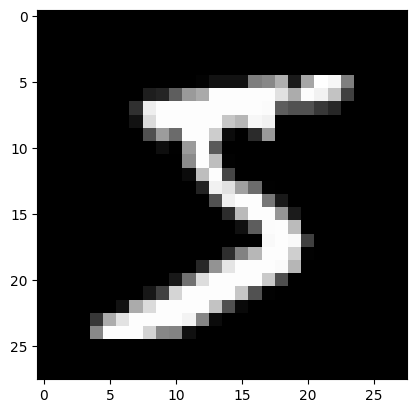

(50000, 784)


In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)

In [ ]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
m, n = x_train.shape

In [ ]:
# using TensorDataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=64)

In [ ]:
# Define parameters (as attributes) and output function (as method) of the model class
import math
from torch import nn

class Mnist_Logistic(nn.Module):  # nn.Module is like a Model baseclass
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [ ]:
# Define the loss function
import torch.nn.functional as F

loss_func = F.cross_entropy # emcompasses log softmax activation func

In [ ]:
# Conpute accuracy of model

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [ ]:
# Train model
from IPython.core.debugger import set_trace
from torch import optim

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for
loss_values = []

def get_model():
    # Initiate model
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)  # Note: model.forward is automatically called by the constructor
        loss = loss_func(pred, yb)
        loss_values.append(loss)

        loss.backward()
        opt.step()
        opt.zero_grad()

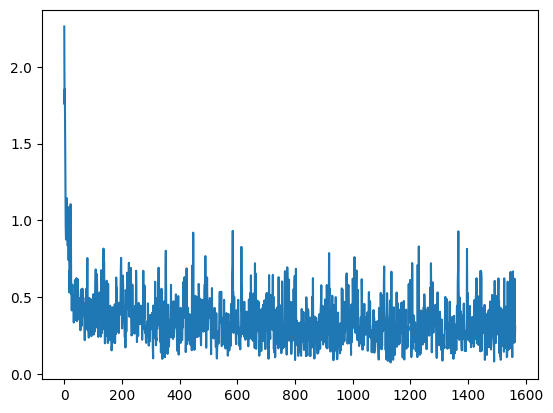

In [ ]:
from matplotlib import pyplot as plt

plt.plot([l.detach().numpy() for l in loss_values])

At this point we have a trained model.

## Eigen Basics

In [ ]:
import numpy as np
from scipy.sparse.linalg import LinearOperator

In [ ]:
def mv(v):
    return np.array([2*v[0], 3*v[1], 4*v[2]])

In [ ]:
A = LinearOperator((3, 3,), matvec=mv)

In [ ]:
A

<3x3 _CustomLinearOperator with dtype=float64>

In [ ]:
A.matvec(np.array([1, 1, 1]))

array([2, 3, 4])

In [ ]:
from scipy.sparse.linalg import eigsh

In [ ]:
eigenvalues, eigenvectors = eigsh(A, k=2, which='LA') # LA = largest algebraic

In [ ]:
eigenvalues

array([3., 4.])

In [ ]:
eigenvectors

array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00,  2.04509905e-16],
       [ 0.00000000e+00,  1.00000000e+00]])

## Hessian Eigenspectrum

### Setting up the training data

In [ ]:
# Create a toy dataset
import torch
torch.manual_seed(0)

# training data has 2 eaxmples
x_train = torch.rand(2, 3)
y_train = torch.rand(2, 2)

In [ ]:
x_train

tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341]])

In [ ]:
y_train

tensor([[0.4901, 0.8964],
        [0.4556, 0.6323]])

In [ ]:
# using TensorDataset and DataLoader
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=1)

### Defining the Model

In [ ]:
import math
from torch import nn

class ToyLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(3, 2) # W is 2 x 3

    def forward(self, xb):
        return self.lin(xb)

In [ ]:
model = ToyLinear()

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1745, -0.1135, -0.5516],
         [-0.3824, -0.2380,  0.0214]], requires_grad=True),
 Parameter containing:
 tensor([0.2282, 0.3464], requires_grad=True)]

In [ ]:
model(x_train)

tensor([[ 0.0057, -0.0243],
        [-0.1794,  0.2363]], grad_fn=<AddmmBackward0>)

### Defining the loss function

In [ ]:
import torch.nn.functional as F

loss_func = F.mse_loss

In [ ]:
model.zero_grad()
loss = loss_func(model(x_train), y_train, reduction='sum')
print(loss)

tensor(1.6425, grad_fn=<MseLossBackward0>)


In [ ]:
# loss.backward()
# for p in model.parameters():
#     print(p.grad)

In [ ]:
from torch.autograd import grad

def compute_loss():
    return loss_func(model(x_train), y_train)

In [ ]:
model.zero_grad()

In [ ]:
grad_loss = grad(compute_loss(), model.parameters(), create_graph=True)

In [ ]:
grad_loss

(tensor([[-0.1621, -0.2837, -0.2228],
         [-0.2546, -0.4145, -0.1663]], grad_fn=<TBackward0>),
 tensor([-0.5597, -0.6583], grad_fn=<ViewBackward0>))

In [ ]:
flat_grad = torch.cat([g.view(-1) for g in grad_loss])

In [ ]:
flat_grad

tensor([-0.1621, -0.2837, -0.2228, -0.2546, -0.4145, -0.1663, -0.5597, -0.6583],
       grad_fn=<CatBackward0>)

In [ ]:
vector = torch.ones_like(flat_grad)

In [ ]:
vector

tensor([1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
gvp = torch.dot(flat_grad, vector)

In [ ]:
gvp

tensor(-2.7220, grad_fn=<DotBackward0>)

In [ ]:
hvp = grad(gvp, model.parameters(), create_graph=True)

In [ ]:
hvp

(tensor([[0.7207, 1.2225, 0.7615],
         [0.7207, 1.2225, 0.7615]]),
 tensor([2.2132, 2.2132]))

In [ ]:
torch.cat([g.contiguous().view(-1) for g in hvp])

tensor([0.7207, 1.2225, 0.7615, 0.7207, 1.2225, 0.7615, 2.2132, 2.2132])

### Computing the HVP

In [ ]:
def hessian_vector_product(vector):
    model.zero_grad()
    grad_loss = grad(compute_loss(), model.parameters(),
                     create_graph=True)
    flat_grad = torch.cat([g.view(-1) for g in grad_loss])
    gvp = torch.dot(flat_grad, vector)
    hvp = grad(gvp, model.parameters(), create_graph=True)
    return torch.cat([g.contiguous().view(-1) for g in hvp])

In [ ]:
hessian_vector_product(torch.tensor([1., 1., 1., 1., 1., 1., 1., 1.]))

tensor([0.7207, 1.2225, 0.7615, 0.7207, 1.2225, 0.7615, 2.2132, 2.2132])

In [ ]:
def matvec(v):
   v_tensor = torch.tensor(v, dtype=torch.float32, device='cpu')
   return hessian_vector_product(v_tensor).cpu().detach().numpy()

In [ ]:
import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh

num_params = sum(p.numel() for p in model.parameters())
linear_operator = LinearOperator((num_params, num_params),
                                     matvec=matvec)
eigenvalues, eigenvectors = eigsh(linear_operator, k=4,
                                  tol=0.001, which='LM',
                                  return_eigenvectors=True)
eigenvectors = np.transpose(eigenvectors)

In [ ]:
eigenvalues, eigenvectors

(array([0.15566683, 0.15566705, 1.5234631 , 1.5234632 ], dtype=float32),
 array([[ 0.00811201,  0.00983971, -0.01465851,  0.41249985,  0.50035834,
         -0.745395  , -0.00301367, -0.15324889],
        [ 0.41249973,  0.5003582 , -0.74539524, -0.00811218, -0.00983956,
          0.0146585 , -0.1532489 ,  0.00301373],
        [ 0.2032492 ,  0.3448863 ,  0.21548319, -0.16686419, -0.28314587,
         -0.17690799,  0.62504184, -0.51314855],
        [ 0.16686416,  0.28314582,  0.17690799,  0.20324922,  0.34488636,
          0.21548317,  0.5131486 ,  0.6250418 ]], dtype=float32))

### From LW

In [ ]:
from scipy.sparse.linalg import LinearOperator, eigsh
from torch.autograd import grad

def get_hessian_eigenvectors(model, loss_fn, train_data_loader,
                             num_batches, device, n_top_vectors,
                             param_extract_fn):
    """
    Args:
        model:             a pytorch model
        loss_fn:           a pytorch loss function
        train_data_loader: a pytorch data loader
        num_batches:       number of batches to use for the hessian
                           calculation
        device:            the device to use for the hessian
                           calculation
        n_top_vectors:     number of top eigenvalues / eigenvectors to
                           return
        param_extract_fn:  a function that takes a model and returns a
                           list of parameters to compute the hessian
                           with respect to (pass None to use all
                           parameters)
    Returns:
        A tuple of (eigenvalues, eigenvectors) where
            eigenvalues:   a numpy array of the top eigenvalues,
                           arranged in increasing order
            eigenvectors:  a numpy array of the top eigenvectors,
                           arranged in increasing order, shape
                           (n_top_vectors, num_params)
    """
    param_extract_fn = param_extract_fn or (lambda x: x.parameters())
    num_params = sum(p.numel() for p in param_extract_fn(model))
    subset_images, subset_labels = [], []
    for batch_idx, (images, labels) in enumerate(train_data_loader):
        if batch_idx >= num_batches:
           break
        subset_images.append(images.to(device))
        subset_labels.append(labels.to(device))
    subset_images = torch.cat(subset_images)
    subset_labels = torch.cat(subset_labels)

    def compute_loss():
       output = model(subset_images)
       return loss_fn(output, subset_labels)

    def hessian_vector_product(vector):
        model.zero_grad()
        grad_params = grad(compute_loss(), param_extract_fn(model),
                           create_graph=True) # True for higher derivatives
        flat_grad = torch.cat([g.view(-1) for g in grad_params])
        grad_vector_product = torch.sum(flat_grad * vector)
        hvp = grad(grad_vector_product, param_extract_fn(model),
                   retain_graph=True)
        return torch.cat([g.contiguous().view(-1) for g in hvp])

    def matvec(v):
       v_tensor = torch.tensor(v, dtype=torch.float32, device=device)
       return hessian_vector_product(v_tensor).cpu().detach().numpy()

    linear_operator = LinearOperator((num_params, num_params),
                                     matvec=matvec)
    eigenvalues, eigenvectors = eigsh(linear_operator, k=n_top_vectors,
                                      tol=0.001, which='LM',
                                      return_eigenvectors=True)
    eigenvectors = np.transpose(eigenvectors)
    return eigenvalues, eigenvectors

In [ ]:
model

ToyLinear(
  (lin): Linear(in_features=3, out_features=2, bias=True)
)

In [ ]:
loss_func

<function torch.nn.functional.mse_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>

In [ ]:
train_dl

In [ ]:
train_dl.dataset.tensors

(tensor([[0.4963, 0.7682, 0.0885],
         [0.1320, 0.3074, 0.6341]]),
 tensor([[0.4901, 0.8964],
         [0.4556, 0.6323]]))

In [ ]:
train_dl.batch_size

1

In [ ]:
get_hessian_eigenvectors(model=model, loss_fn=loss_func,
                         train_data_loader=train_dl, num_batches=5,
                         device='cpu', n_top_vectors=4, param_extract_fn=None)

(array([0.1556669, 0.1556669, 1.523463 , 1.5234632], dtype=float32),
 array([[ 0.26218978,  0.31803378, -0.47378215, -0.3185566 , -0.3864061 ,
          0.575638  , -0.0974069 ,  0.11834781],
        [-0.3185567 , -0.38640615,  0.57563806, -0.2621899 , -0.31803378,
          0.47378212,  0.11834788,  0.09740682],
        [ 0.09786288,  0.16606008,  0.10375345,  0.24408343,  0.41417655,
          0.25877532,  0.3009528 ,  0.750617  ],
        [-0.24408346, -0.41417658, -0.2587753 ,  0.09786302,  0.16606009,
          0.10375339, -0.750617  ,  0.30095273]], dtype=float32))